In [1]:
import os

os.environ['HDF5_DISABLE_VERSION_CHECK'] = "1"

import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr

from sklearn import metrics

from eofs.xarray import Eof
from esem import rf_model

from utils import *

C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.1 when it was built against 1.12.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# path to save the netcdf file
path_output ='outputs_ssp245_prediction_ESEm.nc'


In [3]:
train_files = [ "historical", "ssp585", "ssp126", "ssp370", ]
# Create training and testing arrays
X, solvers = create_predictor_data(train_files)
Y = create_predictdand_data(train_files)



In [4]:

rf_tas = rf_model(X, Y['tas'], random_state=0, bootstrap=True, max_features='auto', **{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4,  'max_depth': 30,})
rf_pr = rf_model(X, Y['pr'], random_state=0, bootstrap=True, max_features='auto', **{'n_estimators': 250, 'min_samples_split': 15, 'min_samples_leaf': 4,'max_depth': 45,})
rf_pr90 = rf_model(X, Y['pr90'], random_state=0, bootstrap=True, max_features='auto',**{'n_estimators': 250, 'min_samples_split': 25, 'min_samples_leaf': 8,'max_depth': 55,})
rf_dtr = rf_model(X, Y["diurnal_temperature_range"], random_state=0, bootstrap=True, max_features='auto',**{'n_estimators': 300, 'min_samples_split': 25, 'min_samples_leaf': 12, 'max_depth': 85,})

rf_tas.train()
rf_pr.train()
rf_pr90.train()
rf_dtr.train()


In [5]:
## Test on SSP245

X_test = get_test_data('ssp245', solvers)
Y_test = create_predictdand_data(['ssp245'])

tas_truth = Y_test["tas"]
pr_truth = Y_test["pr"]
pr90_truth = Y_test["pr90"]
dtr_truth = Y_test["diurnal_temperature_range"]


In [6]:
m_out_tas, _ = rf_tas.predict(X_test)
m_out_pr, _ = rf_pr.predict(X_test)
m_out_pr90, _ = rf_pr90.predict(X_test)
m_out_dtr, _ = rf_dtr.predict(X_test)


In [7]:

xr_output = xr.Dataset(dict(tas=m_out_tas, pr=m_out_pr, pr90=m_out_pr90, diurnal_temperature_range=m_out_dtr)).assign_coords(time=m_out_tas.sample + 2014)
#save output to netcdf 
xr_output.to_netcdf(path_output,'w')

In [8]:
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(dtr_truth[35:], m_out_dtr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr90_truth[35:], m_out_pr90[35:]).mean()}")

RMSE: 0.3187062875001468
RMSE: 0.4239106654993385
RMSE: 0.36763517242665467
RMSE: 0.43472141618566296
RMSE: 0.5767078194454791


RMSE: 0.13426579988568232
RMSE: 0.1433812124226413
RMSE: 0.13790411861197352
RMSE: 0.16467887901091566
RMSE: 0.1581481860130057


RMSE: 0.40785239217243024
RMSE: 0.5858767450692921
RMSE: 0.5035112304396208
RMSE: 0.5273833967195999
RMSE: 0.5379752597855401


RMSE: 1.318967921141969
RMSE: 1.7094038475970195
RMSE: 1.491382925157589
RMSE: 1.5255803034965294
RMSE: 1.5498856840737842


In [12]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, check_scoring, mean_squared_error

def get_rmse_array(truth, pred):
    print(truth.shape, pred.shape)
    weights = np.cos(np.deg2rad(truth.lat))

    return np.sqrt(((truth - pred.reshape(-1, 96,144))**2).weighted(weights).mean(['lat', 'lon'])).data.mean()


In [13]:
%%time
pr_result = permutation_importance(
    rf_pr.model.model, X_test[35:], pr_truth.sel(time=slice(2050,None)), n_repeats=10, random_state=42, n_jobs=1, scoring=make_scorer(get_rmse_array))


(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144) (51, 13824)
(51, 96, 144

In [14]:
importances = rf_pr.model.model.feature_importances_

In [15]:
feature_names = list(X.columns)

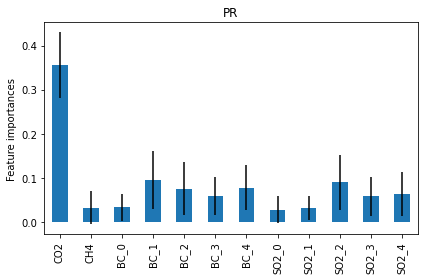

In [16]:
std = np.std([tree.feature_importances_ for tree in rf_pr.model.model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("PR")
ax.set_ylabel("Feature importances")
fig.tight_layout()